In [96]:
import cv2 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import partA_utility as U
import numpy as np
from tqdm import tqdm
from math import tan
import sys
import open3d as o3d

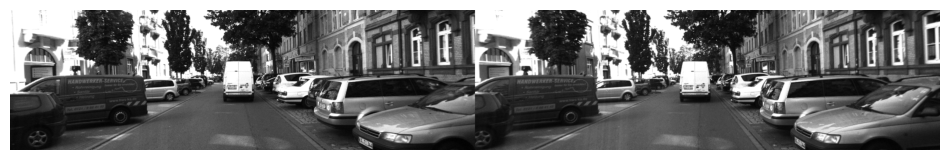

In [97]:
# Setting paths
datapath = "../data_scene_flow/training/"
left = "image_2/"
righ = "image_3/"
leftDataPath = datapath + left

rightDataPath = datapath + righ
file = "000005"

left_frame_path = leftDataPath + file + "_10.png"
right_frame_path = rightDataPath + file + "_10.png"

# Loading the two frames again (both greyscale -> disparity and color version -> visualization)
left_frame = cv2.imread(left_frame_path, cv2.IMREAD_GRAYSCALE)
left_frame_color = cv2.imread(left_frame_path)
right_frame = cv2.imread(right_frame_path, cv2.IMREAD_GRAYSCALE)
right_frame_color = cv2.imread(right_frame_path)

U.visualize_stereo_frames(left_frame, right_frame)

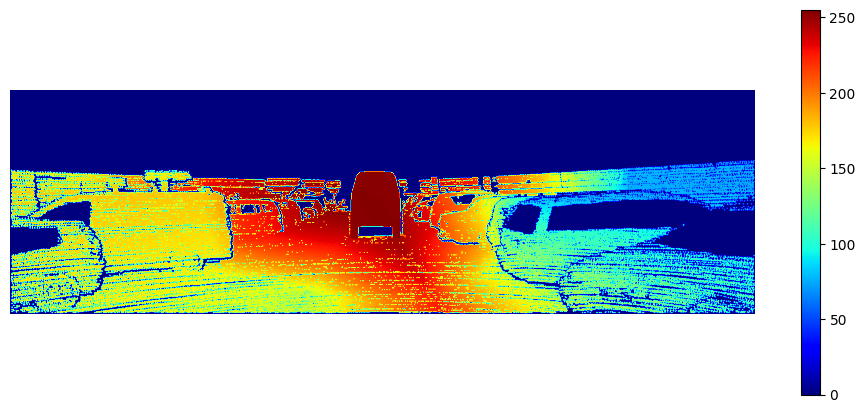

In [98]:
# import grand_trouth disparity map
gt_disparity_map_path = datapath + "viz_flow_occ_dilate_1/" + file + "_10.png"
gt_disparity_map = cv2.imread(gt_disparity_map_path, cv2.IMREAD_GRAYSCALE)
U.visualize_disparity_map(gt_disparity_map)

In [99]:
# calibration camera

# import the calibration matrix
calib_path = "../data_scene_flow_calib/testing/calib_cam_to_cam/"
calib_file = calib_path + file + ".txt"

data_dict = {}

with open(calib_file, 'r') as file:
    lines = file.readlines()

for line in lines:
    line = line.strip()
    if line:
        key, value = line.split(': ')
        data_dict[key] = value

T0_2 = data_dict['T_02']
T0_2 = np.array([float(x) for x in T0_2.split(' ')])

T0_3 = data_dict['T_03']
T0_3 = np.array([float(x) for x in T0_3.split(' ')])

baseline = np.linalg.norm(T0_3 - T0_2)

print(T0_2)
print(T0_3)
print("baseline: ", baseline)

P0_2 = data_dict['P_rect_02']
P0_2 = np.array([float(x) for x in P0_2.split(' ')]).reshape(3, 4)

P0_3 = data_dict['P_rect_03']
P0_3 = np.array([float(x) for x in P0_3.split(' ')]).reshape(3, 4)

focal_length = P0_2[0, 0]
print("focal length: ", focal_length, " pixels")

[0.05956621 0.00029001 0.00257721]
[-0.473105    0.00555147 -0.00525088]
baseline:  0.532754708932503
focal length:  721.5377  pixels


100%|██████████| 367/367 [00:59<00:00,  6.12it/s]


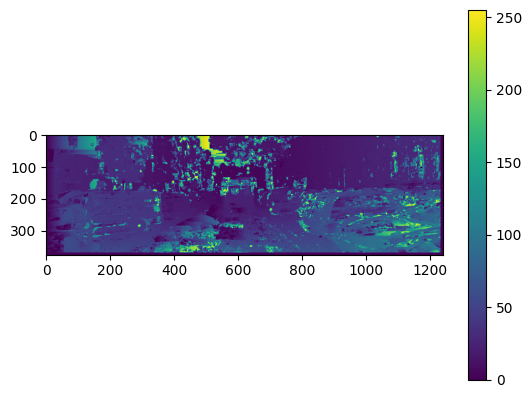

In [100]:
# setting the block size
block_size = 8


frame_shape = left_frame.shape 

# Create an image to store the disparity
disparity_map = np.zeros_like(left_frame)


# Parse the pixels - Use tqdm to monitor the process. 
for i in tqdm(range(frame_shape[0] - block_size)):
    
    for j in range(frame_shape[1] - block_size):
        
        # get the tamplate form the left frame
        template = left_frame[i:i+block_size, j:j+block_size]

        # get the crop/roi from the right frame
        # roi -> region of interest
        roi = right_frame[i:i+block_size,0:j+block_size]

        # do the block matching
        res = cv2.matchTemplate(roi, template, cv2.TM_SQDIFF)

        # locate the coordiante od the best match
        _, _, loc_min, _ = cv2.minMaxLoc(res)

        # calculate the disparity value (should be positive)
        # loc_min[0] -> the first element in column
        disparity = j - loc_min[0]

        # Save the disparity value in the map
        disparity_map[i, j] = disparity


plt.imshow(disparity_map)
plt.colorbar()
plt.show()

100%|██████████| 367/367 [00:11<00:00, 31.27it/s]


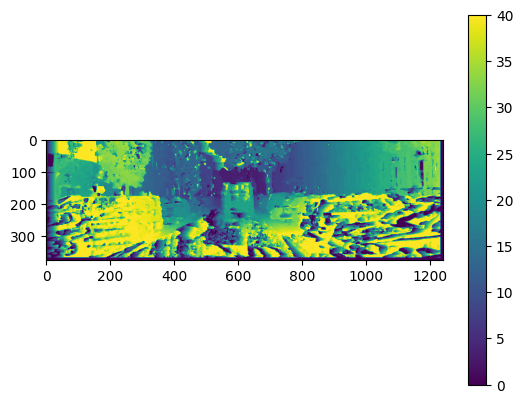

In [101]:
# Create an image to store the disparity
disparity_map = np.zeros_like(left_frame)
max_num_blocks = 5

# Parse the pixels
for i in tqdm(range(frame_shape[0] - block_size)):
    for j in range(frame_shape[1] - block_size):
        
        template = left_frame[i:i+block_size, j:j+block_size]

        start = max(0,j - max_num_blocks * block_size)
        end = j+block_size
        
        roi = right_frame[i: i + block_size, start : end]

        res = cv2.matchTemplate(roi, template, cv2.TM_SQDIFF)

        _, _, min_loc, _ = cv2.minMaxLoc(res)

        disparity = j - (min_loc[0] + start)

        disparity_map[i, j] = disparity


plt.imshow(disparity_map)
plt.colorbar()
plt.show()

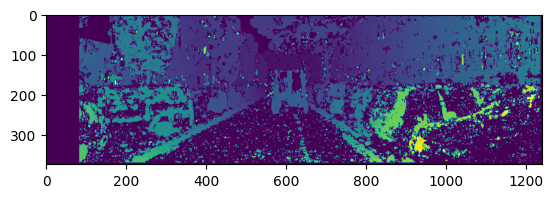

In [102]:
block_size = 9
num_disparities = 5 * 16


stereo = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)
cv_disparity = stereo.compute(left_frame, right_frame)
plt.imshow(cv_disparity)
plt.show()

In [105]:
# disparity_map = gt_disparity_map
disparity_map = cv_disparity
rows, columns = disparity_map.shape[0], disparity_map.shape[1]

# finding the center of the image
u0 = columns / 2 
v0 = rows / 2

vertices = []
colors = []

for i in range(columns):
    for j in range(rows):
        
        d = disparity_map[j][i] / columns
        color = left_frame_color[j,i]

        if d==0:
            continue
        else:
            z = focal_length * (baseline / d)
            x = ((i-u0)) * (z / focal_length)
            y = - ((j-v0)) * (z / focal_length)
            
            if z>0:
                vertices.append(np.array([x,y,-z]))
                colors.append(np.array(color / 255.0))



vertices = np.stack(vertices)
colors = np.stack(colors)


In [106]:
# from sklearn.cluster import DBSCAN

# labels = DBSCAN(5,min_samples=50).fit(vertices)

# labels = labels.labels_
# vertices = vertices[labels > -1]
# colors = colors[labels>-1]

# save vertices
np.save("vertices.npy", vertices)
np.save("colors.npy", colors)